In [1]:
%load_ext autoreload
%autoreload 2

In [159]:
%matplotlib inline

import sys
sys.path.append('../src/')

import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr

from scipy.optimize import curve_fit, minimize

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

from sklearn.linear_model import LinearRegression

from epsilon_tools import *
from tools import str2date, avg_funs, integrate_columns, first_finite
from qc import qc_turbulence

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='poster', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

In [367]:
def qc_velocity(data):
    Wmin = 0.05
    RotPmax = 20
    verrmax = 0.1 # original 0.02

    # where cond:  what to keep!
    uv_mask = (np.abs(data.W) > Wmin) & (data.RotP < RotPmax)
    u1_mask = uv_mask & (data.verr1 < verrmax)
    u2_mask = uv_mask & (data.verr2 < verrmax)

    data['u1'] = data.u1.where(u1_mask)
    data['u2'] = data.u2.where(u2_mask)
    data['v1'] = data.u1.where(u1_mask)
    data['v2'] = data.v2.where(u2_mask)

    data['u'] = avg_funs(data['u1'], data['u2'])
    data['v'] = avg_funs(data['v1'], data['v2'])
    data['dudz'] = avg_funs(data['du1dz'], data['du2dz'])
    data['dvdz'] = avg_funs(data['dv1dz'], data['dv2dz'])
    data['S2'] = data.dudz**2 + data.dvdz**2

    data = data.drop([
        'W', 'RotP', 'verr1', 'verr2', 'u1', 'u2', 'v1', 'v2', 'du1dz',
        'du2dz', 'dv1dz', 'dv2dz'
    ])
    return data

def integrate_columns(data,lower,upper):
    '''
        Integrate each profile over depth range, e.g., MLD to 0.
    '''
    # mld=data.mld
    data = data.where( (data.z >= lower) & (data.z < upper) )
    data['z'] = data.z * (-1)
    array = []
    for t in range(data.time.size):
        # TODO: could do better here with simpson's rule
        if data.isel(time=t).dropna('z').size > 3:
            array.append(data.isel(time=t).dropna('z').integrate('z'))
        else:
            array.append(data.isel(time=t).dropna('z').integrate('z')*np.nan)

    # find zmin observed depth
    if np.mean(upper)==0:
        zmin = data[first_finite(data,0)].z
    else:
        zmin = upper
    # xr.concat(array/(lower-zmin), dim='time')
    return xr.concat(array, dim='time')

In [368]:
floatid = '7781a'
raw = xr.open_dataset(f'../data/xarray/xr_{floatid}.nc')
cfs = xr.open_dataset('../data/metdata/float_cfs_hourly.nc')
cfs = cfs.sel(floatid=f'{floatid}')
emp = xr.open_dataset('../data/CFS/croppped_emp_field.nc')
raw = qc_turbulence(raw)
raw = qc_velocity(raw)

In [369]:
raw['mld'] = ('time', raw.z.where(raw.S2 == raw.S2.max(dim='z')).mean(dim='z'))
raw['Ri'] = raw.n2/raw.S2

# extract uppermost velocity measuremnt
indu = first_finite(raw.u, 0).fillna(0).astype(int)
indv = first_finite(raw.v, 0).fillna(0).astype(int)

raw['u_surf'] = raw.u[indu]
raw['v_surf'] = raw.v[indv]

indS = first_finite(raw.S, 0).fillna(0).astype(int)
indT = first_finite(raw.T, 0).fillna(0).astype(int)
raw['S_surf'] = 0.5*(raw.S[indS]+raw.S[indS+1])
raw['T_surf'] = 0.5*(raw.T[indT]+raw.T[indT+1])

In [370]:
cfs = cfs.interp_like(raw, method='linear')
rho0=raw.rho0.mean()
g = 9.81

raw['hke'] = 0.5*( (raw.u - raw.u.mean(dim='z'))**2+(raw.u - raw.u.mean(dim='z'))**2 )*rho0
raw['ape'] = (raw.rho0-raw.rho0.rolling(time=10).mean(dim='time'))*g*raw.z
# raw['emp'] = ('time', interp_in_space(raw, emp).EMP)
# raw['emp'] = raw.emp/(100*86400)
# raw['qnet'] = ('time', cfs['Qnet'])
raw['tx'] = ('time', cfs['tx'])
raw['ty'] = ('time', cfs['ty'])
raw['taudotu'] = raw.u_surf * raw.tx + raw.v_surf * raw.ty
raw['tau'] = ('time', np.sqrt( raw.tx**2 + raw.ty**2 ))
raw['uprime'] = np.sqrt( raw.tau/raw.rho0.mean() )
raw['shear_prod'] = -raw.uprime**3/(0.4*raw.z) 
raw['shear_prod'] = raw.shear_prod.transpose('z','time').where( raw.shear_prod<1e5)
# raw['mshear_prod'] = ('time', -integrate_columns(raw.shear_prod, raw.mld))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Reductions will be applied along the rolling dimension 'time'. Passing the 'dim' kwarg to reduction operations has no effect and will raise an error in xarray 0.16.0.
  


In [653]:
subset = raw.sel(time=slice('2016-10-01','2016-10-21'))

(-200, 0)

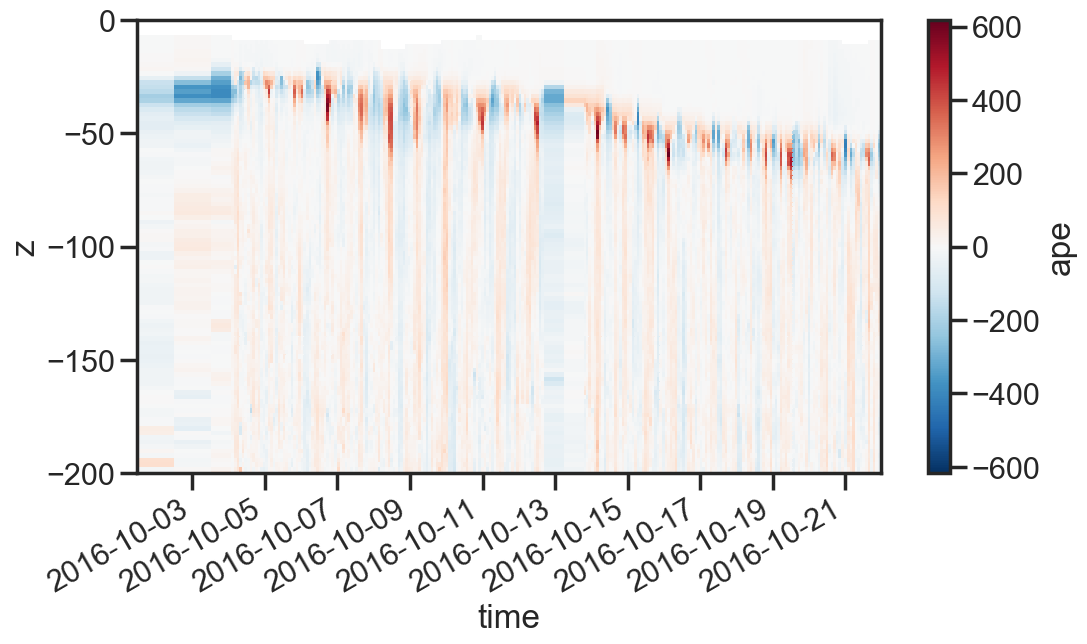

In [608]:
# subset.hke.plot()
subset.ape.plot()
plt.ylim(-200,0)

In [654]:
g=9.81
zmin=-200
subset['ape_ml'] = ('time', integrate_columns(subset.ape, subset.mld,0)/1000 ) # divide by 1000 to get kJ
subset['ape_py'] = ('time', integrate_columns(subset.ape, zmin, subset.mld)/1000)

subset['hke_ml'] = ('time', integrate_columns(subset.hke, subset.mld,0)/1000)
subset['hke_py'] = ('time', integrate_columns(subset.hke, zmin, subset.mld)/1000)

subset['eps_ml'] = ('time', integrate_columns(subset.eps, subset.mld,0))
subset['eps_py'] = ('time', integrate_columns(subset.eps, zmin, subset.mld))

subset['hke_full'] = ('time', integrate_columns(subset.hke, zmin,0)/1000 )
subset['ape_full'] = ('time', integrate_columns(subset.ape, zmin,0)/1000 )

subset['ape_prime_ml'] = subset.ape_ml #- subset.ape_ml.isel(time=slice(0,10)).mean()
subset['ape_prime_py'] = subset.ape_py #- subset.ape_py.isel(time=slice(0,10)).mean()

subset['hke_prime_ml'] = subset.hke_ml #- subset.hke_ml.isel(time=slice(0,10)).mean()
subset['hke_prime_py'] = subset.hke_py #- subset.hke_py.isel(time=slice(0,10)).mean()

Text(0, 0.5, 'Energy [$kJ~m^{-2}$]')

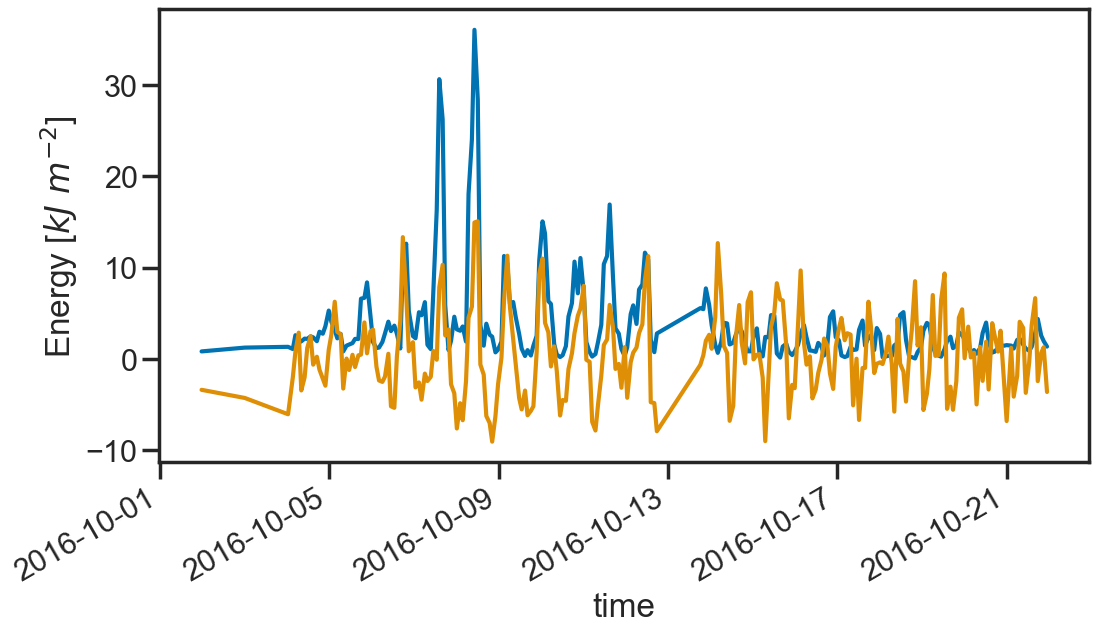

In [655]:
subset.hke_full.plot()
subset.ape_full.plot()

plt.ylabel('Energy [$kJ~m^{-2}$]')

In [611]:
taudotu_series = subset.taudotu.to_series()
taudotu_positive = taudotu_series[taudotu_series>0]*3
tau_series = subset.tau.to_series()

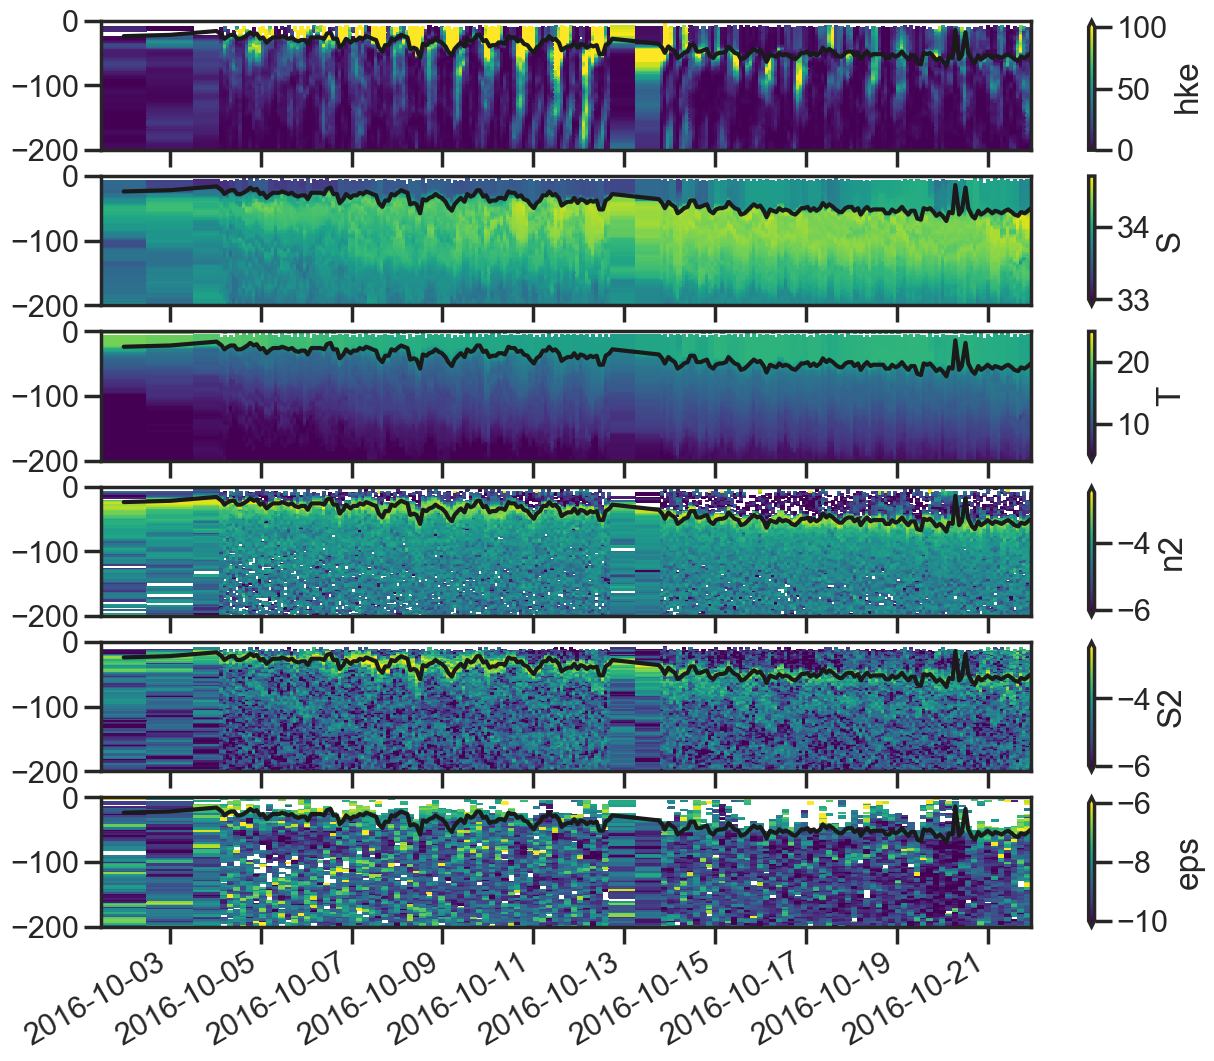

In [612]:
zmin=-200
f,ax = plt.subplots(6,1,figsize=(15,12), sharex=True)

subset.hke.plot(vmin=0,vmax=100, ax=ax[0])
subset.mld.plot(color='k', ax=ax[0], label='HKE')
ax[0].set_ylim(zmin,0)
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)

subset.S.plot(vmin=33,vmax=34.7, ax=ax[1])
subset.mld.plot(color='k', ax= ax[1])
ax[1].set_ylim(zmin,0)
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)

subset.T.plot(vmin=5,vmax=25, ax=ax[2])
subset.mld.plot(color='k', ax= ax[2])
ax[2].set_ylim(zmin,0)
ax[2].set_xlabel(None)
ax[2].set_ylabel(None)

subset.n2.pipe(np.log10).plot(vmin=-6,vmax=-2.5, ax=ax[3])
subset.mld.plot(color='k', ax= ax[3])
ax[3].set_ylim(zmin,0)
ax[3].set_xlabel(None)
ax[3].set_ylabel(None)

subset.S2.pipe(np.log10).plot(vmin=-6,vmax=-2.5, ax=ax[4])
subset.mld.plot(color='k', ax=ax[4])
ax[4].set_ylim(zmin,0)
ax[4].set_xlabel(None)
ax[4].set_ylabel(None)

subset.eps.dropna(dim='time',how='all').pipe(np.log10).plot(vmin=-10,vmax=-6, ax=ax[5])
subset.mld.plot(color='k', ax= ax[5])
ax[5].set_ylim(zmin,0)
ax[5].set_xlabel(None)
ax[5].set_ylabel(None);

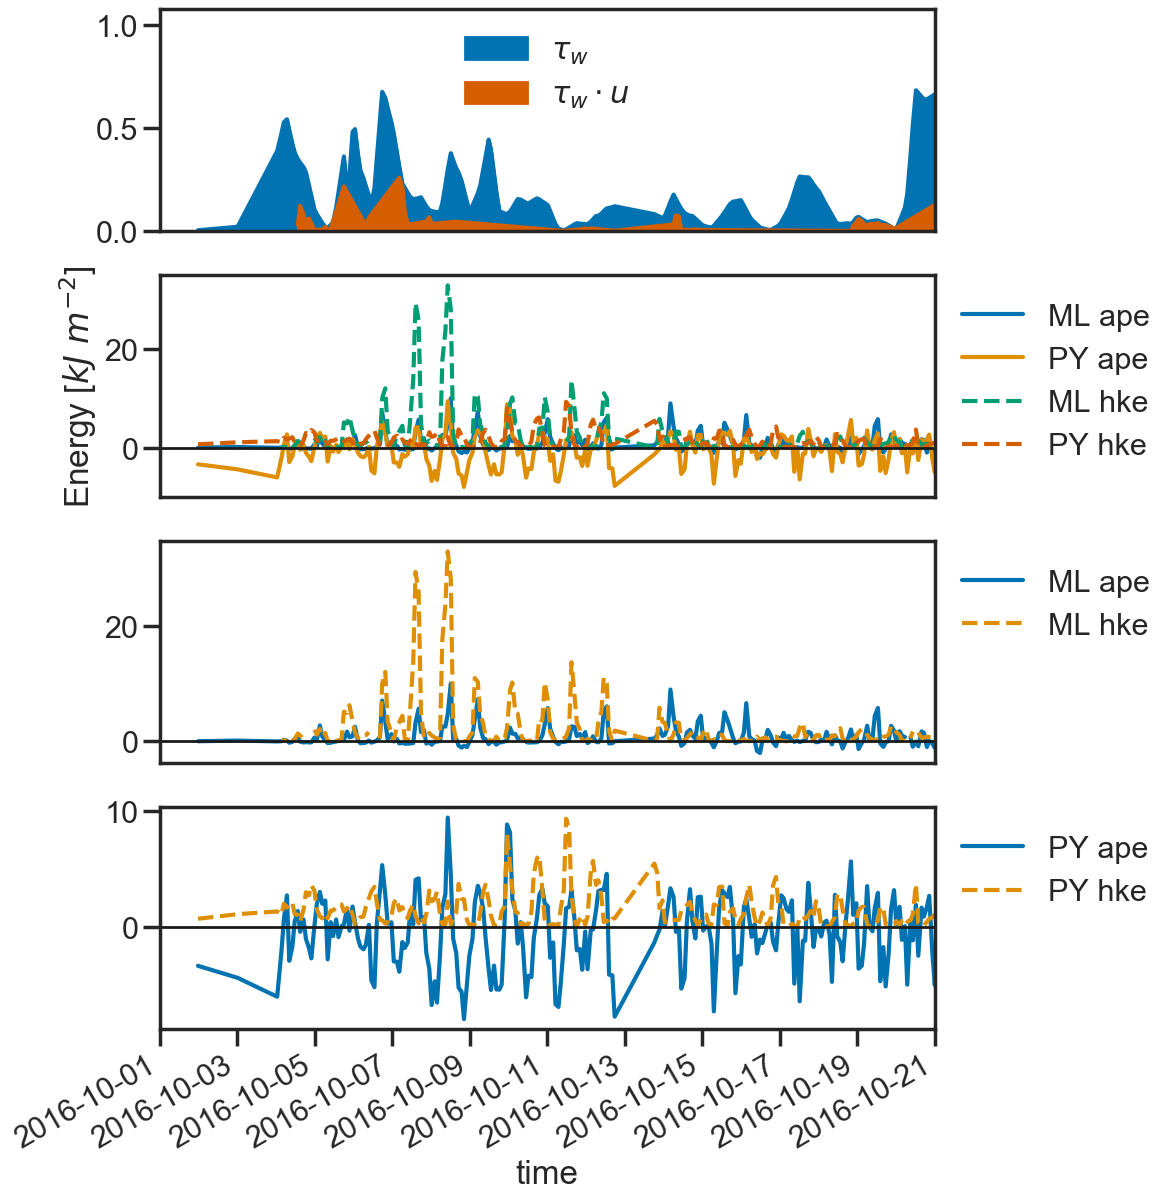

In [613]:
f = plt.figure(figsize=(10,15))

nplots=4
ax = f.add_subplot(nplots,1,1)
tau_series.plot.area(color='b',ax=ax, label=r'$\tau_w$')
taudotu_positive.plot.area(color='r',ax=ax,label=r'$\tau_w \cdot u$')

ax.set_xticks([])
ax.set_xlabel(None)
ax.legend()
ax.set_xlim('2016-10-01','2016-10-21')

ax = f.add_subplot(nplots,1,2)
subset.ape_prime_ml.plot(label=r'ML ape', ax=ax)
subset.ape_prime_py.plot(label=r'PY ape', ax=ax)
subset.hke_prime_ml.plot(label=r'ML hke',linestyle='dashed', ax=ax)
subset.hke_prime_py.plot(label=r'PY hke',linestyle='dashed', ax=ax)

ax.axhline(0, color='k',lw=2)
ax.legend()
ax.set_ylabel('Energy [$kJ~m^{-2}$]');
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));
ax.set_xlim('2016-10-01','2016-10-21')
ax.set_xticks([])
ax.set_xlabel(None)

ax = f.add_subplot(nplots,1,3)
# taudotu_positive.plot(color='r',ax=ax,label=r'$\tau_w \cdot u$')
subset.ape_prime_ml.plot(label=r'ML ape', ax=ax)
subset.hke_prime_ml.plot(label=r'ML hke',linestyle='dashed', ax=ax)
ax.set_ylabel(None)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));
ax.axhline(0, color='k',lw=2);
ax.set_xlim('2016-10-01','2016-10-21');
ax.set_xticks([])
ax.set_xlabel(None)

ax = f.add_subplot(nplots,1,4)
# taudotu_positive.plot(color='r',ax=ax,label=r'$\tau_w \cdot u$')
subset.ape_prime_py.plot(label=r'PY ape', ax=ax)
subset.hke_prime_py.plot(label=r'PY hke',linestyle='dashed', ax=ax)
ax.set_ylabel(None)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));
ax.axhline(0, color='k',lw=2);
ax.set_xlim('2016-10-01','2016-10-21');

In [656]:
import xrscipy

In [657]:
from scipy.integrate import cumtrapz

In [616]:
subset['dt'] = ('time', subset.time.values.astype(int)*1e-9) 

In [658]:
datetime = pd.to_datetime( subset.time.values )

In [659]:
diff = datetime - datetime[0]

In [666]:
subset['diff'] = ('time',diff.total_seconds())

In [667]:
subset = subset.swap_dims({'time':'diff'})

In [668]:
subset

<xarray.Dataset>
Dimensions:       (diff: 245, z: 501)
Coordinates:
    time          (diff) datetime64[ns] 2016-10-01T23:38:21.532953 ... 2016-10-21T22:49:04.274733
  * z             (z) float64 -0.0 -1.985 -3.969 -5.954 ... -986.0 -988.0 -989.9
    pressure      (z) float64 ...
    lat           (diff) float64 ...
    lon           (diff) float64 ...
  * diff          (diff) float64 0.0 8.826e+04 1.765e+05 ... 1.718e+06 1.725e+06
Data variables:
    sigma         (z, diff) float64 ...
    T             (z, diff) float64 21.01 20.51 nan nan ... nan nan nan nan
    S             (z, diff) float64 33.57 33.35 nan nan ... nan nan nan nan
    n2            (z, diff) float64 ...
    rho0          (z, diff) float64 1.023e+03 1.023e+03 nan nan ... nan nan nan
    kT            (z, diff) float64 0.01015 8.475e-05 nan nan ... nan nan nan
    chi           (z, diff) float64 3.739e-05 1.108e-07 nan nan ... nan nan nan
    eps           (z, diff) float64 5.506e-06 2.337e-08 nan nan ... nan nan nan
    u             (z, diff) float64 nan nan nan nan nan ... nan nan nan nan nan
    v             (z, diff) float64 nan nan nan nan nan ... nan nan nan nan nan
    dudz          (z, diff) float64 nan nan nan nan nan ... nan nan nan nan nan
    dvdz          (z, diff) float64 nan nan nan nan nan ... nan nan nan nan nan
    S2            (z, diff) float64 nan nan nan nan nan ... nan nan nan nan nan
    mld           (diff) float64 -23.81 -21.83 -15.88 ... -57.55 -54.57 -49.61
    Ri            (z, diff) float64 nan nan nan nan nan ... nan nan nan nan nan
    u_surf        (diff) float64 0.1847 0.11 0.1449 ... -0.08339 -0.04363
    v_surf        (diff) float64 0.03051 0.06915 0.1296 ... -0.03571 0.018
    S_surf        (diff) float64 33.57 33.35 33.21 33.22 ... 33.78 33.81 33.83
    T_surf        (diff) float64 21.01 20.51 19.67 19.7 ... 16.68 16.68 16.73
    hke           (z, diff) float64 nan nan nan nan nan ... nan nan nan nan nan
    ape           (z, diff) float64 nan nan nan nan nan ... nan nan nan nan nan
    tx            (diff) float64 -0.002649 -0.01402 -0.388 ... -0.4842 -0.4072
    ty            (diff) float64 0.002018 -0.01438 0.007296 ... 0.4099 0.349
    taudotu       (diff) float64 -0.0004277 -0.002537 ... 0.02574 0.02405
    tau           (diff) float64 0.00333 0.02008 0.3881 ... 0.7086 0.6344 0.5363
    uprime        (diff) float64 0.001801 0.004423 0.01944 ... 0.02486 0.02286
    shear_prod    (z, diff) float64 nan nan nan ... 4.581e-08 3.88e-08 3.016e-08
    ape_ml        (diff) float64 0.03519 0.151 -0.0045 ... -0.04379 -0.2019
    ape_py        (diff) float64 -3.351 -4.383 -6.014 ... 0.1508 1.342 -3.189
    hke_ml        (diff) float64 0.064 nan nan 0.02578 ... 1.751 1.206 0.4347
    hke_py        (diff) float64 0.7041 1.101 1.334 ... 0.8123 0.7395 0.9146
    eps_ml        (diff) float64 1.641e-05 8.442e-08 1.254e-06 ... 1.401e-05 nan
    eps_py        (diff) float64 6.835e-07 1.336e-07 5.973e-06 ... 1.58e-07 nan
    hke_full      (diff) float64 0.8326 1.249 1.334 1.093 ... 2.566 1.959 1.362
    ape_full      (diff) float64 -3.369 -4.26 -6.04 ... 0.668 1.289 -3.603
    ape_prime_ml  (diff) float64 0.03519 0.151 -0.0045 ... -0.04379 -0.2019
    ape_prime_py  (diff) float64 -3.351 -4.383 -6.014 ... 0.1508 1.342 -3.189
    hke_prime_ml  (diff) float64 0.064 nan nan 0.02578 ... 1.751 1.206 0.4347
    hke_prime_py  (diff) float64 0.7041 1.101 1.334 ... 0.8123 0.7395 0.9146
Attributes:
    floatid:  7781a

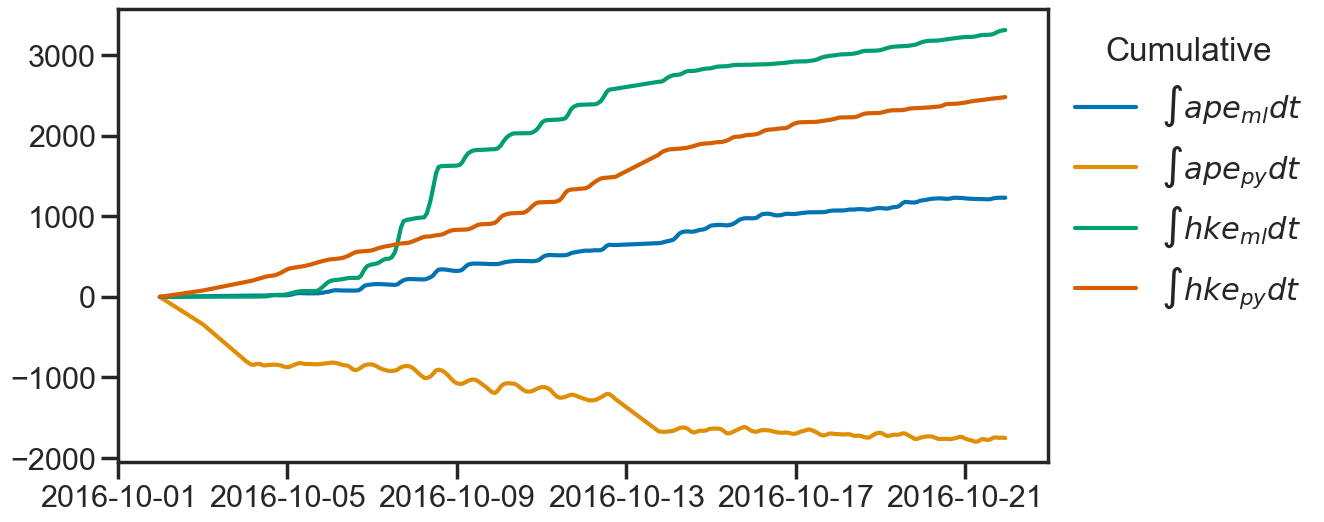

In [674]:
plt.plot(subset.time, xrscipy.integrate.cumtrapz( subset.ape_prime_ml.fillna(0), coord='diff', initial =0)/1000, label='$\int ape_{ml} dt$')
plt.plot(subset.time, xrscipy.integrate.cumtrapz( subset.ape_prime_py.fillna(0), coord='diff', initial =0)/1000, label='$\int ape_{py} dt$' )

plt.plot(subset.time, xrscipy.integrate.cumtrapz( subset.hke_prime_ml.fillna(0), coord='diff', initial =0)/1000 , label='$\int hke_{ml} dt$');
plt.plot(subset.time, xrscipy.integrate.cumtrapz( subset.hke_prime_py.fillna(0), coord='diff', initial =0)/1000 , label='$\int hke_{py} dt$');

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Cumulative');

In [439]:
def divby100(df):
    return df/100

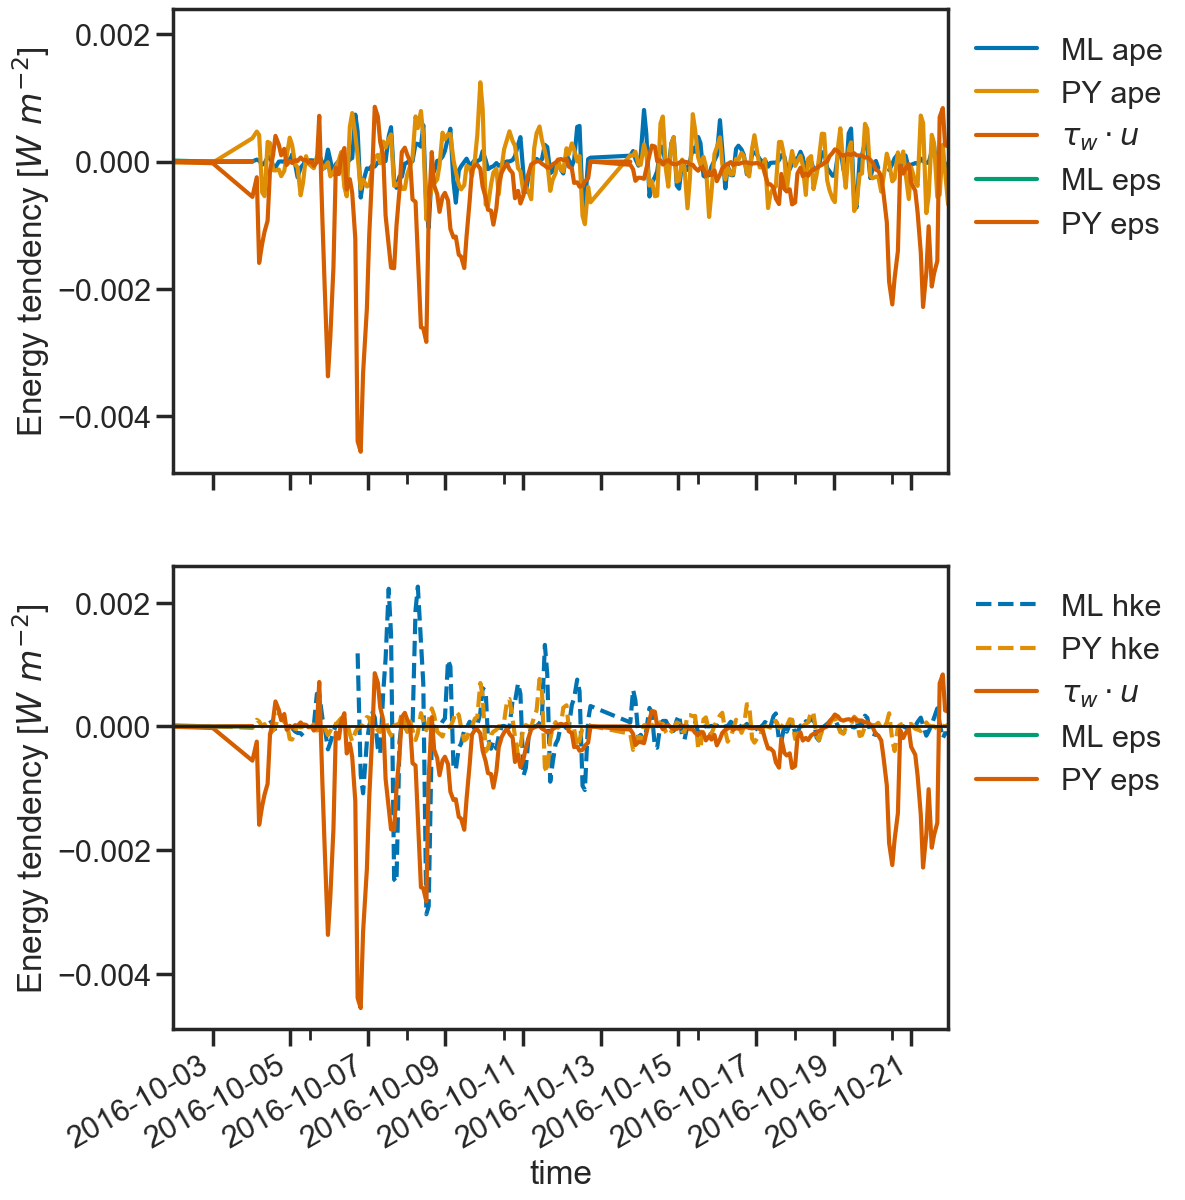

In [440]:
f = plt.figure(figsize=(10,15))
ax = f.add_subplot(2,1,1)
subset.ape_prime_ml.differentiate('time',datetime_unit='s').plot(label=r'ML ape', ax=ax)
subset.ape_prime_py.differentiate('time',datetime_unit='s').plot(label=r'PY ape', ax=ax)
taudotu_series.apply(divby100).plot(color='r',ax=ax,label=r'$\tau_w \cdot u$')
subset.eps_ml.plot(label=r'ML eps',ax=ax)
subset.eps_py.plot(label=r'PY eps',ax=ax)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));
ax.set_ylabel('Energy tendency [$W~m^{-2}$]');

ax = f.add_subplot(2,1,2,sharex=ax)
subset.hke_prime_ml.differentiate('time',datetime_unit='s').plot(label=r'ML hke',linestyle='dashed', ax=ax)
subset.hke_prime_py.differentiate('time',datetime_unit='s').plot(label=r'PY hke',linestyle='dashed', ax=ax)
taudotu_series.apply(divby100).plot(color='r',ax=ax,label=r'$\tau_w \cdot u$')
subset.eps_ml.plot(label=r'ML eps',ax=ax)
subset.eps_py.plot(label=r'PY eps',ax=ax)
ax.set_ylabel('Energy tendency [$W~m^{-2}$]');

ax.axhline(0, color='k',lw=2)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));

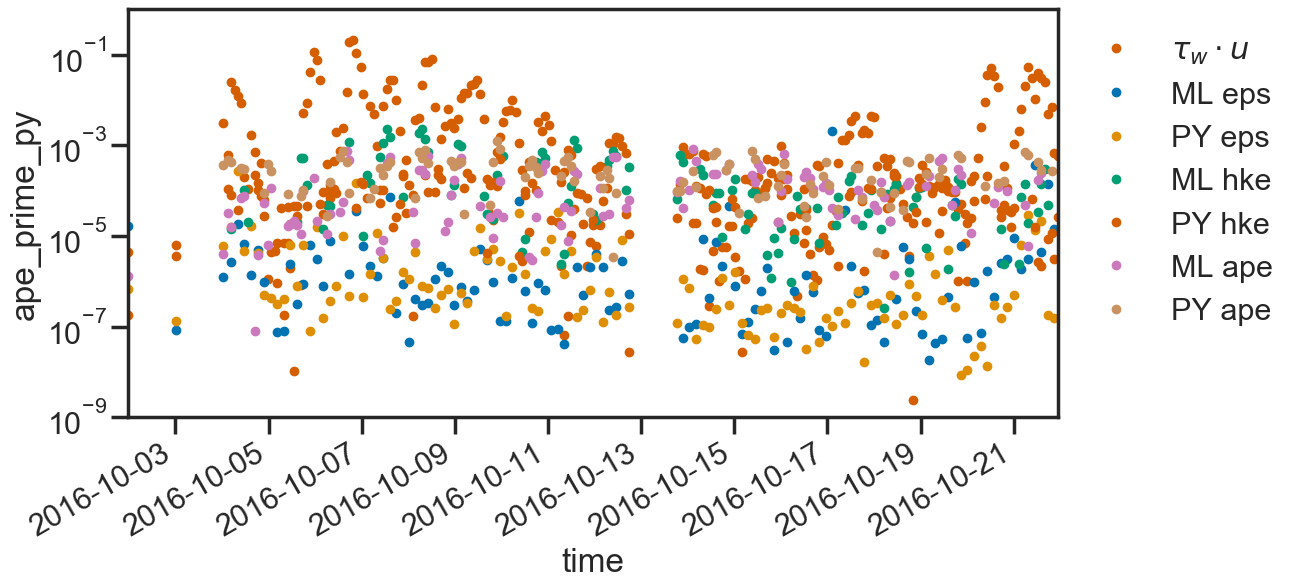

In [381]:
taudotu_series.pipe(np.square).plot(color='r',label=r'$\tau_w \cdot u$', marker='.',lw=0)

subset.eps_ml.plot(label=r'ML eps',marker='.',lw=0)
subset.eps_py.plot(label=r'PY eps',marker='.',lw=0)

subset.hke_prime_ml.differentiate('time',datetime_unit='s').plot(label=r'ML hke', marker='.',lw=0)
subset.hke_prime_py.differentiate('time',datetime_unit='s').plot(label=r'PY hke', marker='.',lw=0)

subset.ape_prime_ml.differentiate('time',datetime_unit='s').plot(label=r'ML ape', marker='.',lw=0)
subset.ape_prime_py.differentiate('time',datetime_unit='s').plot(label=r'PY ape', marker='.',lw=0)

plt.ylim(1e-9,1e0)
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1));